# Tuning LGBM

In [34]:
import utils as utils
import holidays
import re
from collections import Counter
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import boxcox, boxcox_normmax, probplot
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# LEITURA

In [35]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [36]:
incidentes = import_data("../input/train_data_outliers_cleaned.csv")
testev= import_data("../input/test_data_outliers_cleaned.csv")

Memory usage of dataframe is 0.76 MB
Memory usage after optimization is: 0.13 MB
Decreased by 83.1%
Memory usage of dataframe is 0.17 MB
Memory usage after optimization is: 0.03 MB
Decreased by 81.5%


In [37]:
incidentes = incidentes.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [38]:
incidentes.head()

,Unnamed0,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,Regional,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0,0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,15,0,3,23,74,0,0,1
1,1,0,385,0,12.0,1007.0,91.0,1.0,0,0,1,0,25,5,12,18,359,3,1,1
2,2,0,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,12,4,3,15,71,0,0,1
3,3,2,2297,2,15.0,1028.0,75.0,1.0,0,4,10,1,29,2,9,9,272,3,0,1
4,4,0,0,2,27.0,1020.0,52.0,1.0,0,3,5,0,13,6,6,11,164,1,0,1


In [39]:
incidentes = incidentes.drop(['Unnamed0'], axis=1)

In [40]:
incidentes.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,Regional,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0,0,0,12.0,1013.0,70.0,1.0,0,0,0,0,15,0,3,23,74,0,0,1
1,0,385,0,12.0,1007.0,91.0,1.0,0,0,1,0,25,5,12,18,359,3,1,1
2,0,69,2,14.0,1025.0,64.0,0.0,0,1,0,0,12,4,3,15,71,0,0,1
3,2,2297,2,15.0,1028.0,75.0,1.0,0,4,10,1,29,2,9,9,272,3,0,1
4,0,0,2,27.0,1020.0,52.0,1.0,0,3,5,0,13,6,6,11,164,1,0,1


In [41]:
#divisão do target
x = incidentes.drop(['incidents'], axis=1)
y = incidentes['incidents']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

This function defines a learning rate schedule that decreases the learning rate by a factor of 0.99 every time the current_iter argument increases by 1. The learning rate will never go below 1e-3 (0.001). Here's an example of how you could use this function to train a model using stochastic gradient descent with a fixed number of iterations

In [43]:
def learning_rate_010_decay_power_099(current_iter): #2
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter): #1
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter): #3
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

### OBSERVAR PARÂMETROS

In [44]:

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc_mu', 
            "eval_set" : [(X_test,y_test)],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_005_decay_power_099)],
            'verbose': 100}

In [45]:

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
             }

In [46]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=5000, random_state=42)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='accuracy',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [47]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
[100]	valid_0's auc_mu: 0.978072	valid_0's multi_logloss: 0.460653
[200]	valid_0's auc_mu: 0.9823	valid_0's multi_logloss: 0.379166
[300]	valid_0's auc_mu: 0.984063	valid_0's multi_logloss: 0.337993
[400]	valid_0's auc_mu: 0.984762	valid_0's multi_logloss: 0.317251
[500]	valid_0's auc_mu: 0.985227	valid_0's multi_logloss: 0.302258
[600]	valid_0's auc_mu: 0.985692	valid_0's multi_logloss: 0.293145
[700]	valid_0's auc_mu: 0.985985	valid_0's multi_logloss: 0.285916
[800]	valid_0's auc_mu: 0.986471	valid_0's multi_logloss: 0.279305
[900]	valid_0's auc_mu: 0.986829	valid_0's multi_logloss: 0.274908
[1000]	valid_0's auc_mu: 0.987014	valid_0's multi_logloss: 0.271653
[1100]	valid_0's auc_mu: 0.987128	valid_0's multi_logloss: 0.26856
[1200]	valid_0's auc_mu: 0.987321	valid_0's multi_logloss: 0.264532
Early stopping, best iteration is:
[1184]	valid_0's auc_mu: 0.987362	val

In [49]:
opt_parameters= {'colsample_bytree': 0.952164731370897, 'min_child_samples': 111, 'min_child_weight': 0.01, 'num_leaves': 38, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.3029313662262354} 

In [ ]:
#opt_parameters = {'colsample_bytree': 0.952164731370897, 'min_child_samples': 111, 'min_child_weight': 0.01, 'num_leaves': 38, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.3029313662262354} 

In [50]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid_0's auc_mu: 0.99333	valid_0's multi_logloss: 0.186248
Early stopping, best iteration is:
[125]	valid_0's auc_mu: 0.993517	valid_0's multi_logloss: 0.185107


LGBMClassifier(colsample_bytree=0.952164731370897, min_child_samples=111,
               min_child_weight=0.01, n_estimators=5000, num_leaves=38,
               random_state=42, reg_alpha=0, reg_lambda=0.1,
               subsample=0.3029313662262354)

<AxesSubplot: >

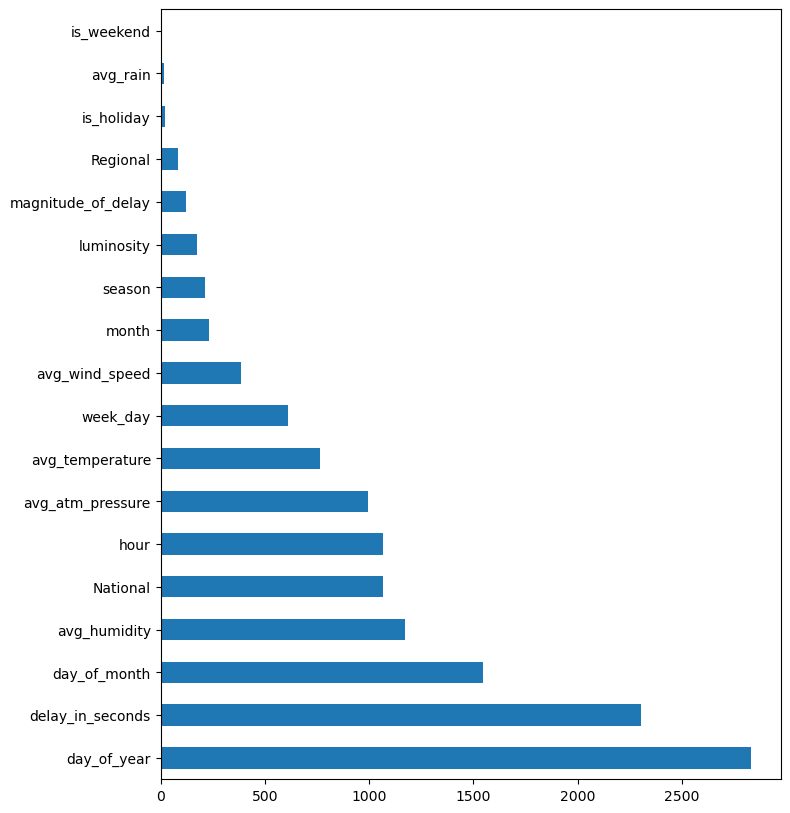

In [51]:
feat_imp = pd.Series(clf_final.feature_importances_, index=x.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

In [52]:
probabilities = clf_final.predict(X_test)

report = classification_report(y_test, probabilities)
print(report)
accuracy = accuracy_score(y_test, probabilities)
print(accuracy)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.86      0.92      0.88       189
           2       0.85      0.77      0.81       144
           3       0.90      0.89      0.90       265
           4       0.89      0.92      0.91       135

    accuracy                           0.92      1250
   macro avg       0.90      0.90      0.90      1250
weighted avg       0.92      0.92      0.92      1250

0.9248
